## Chinese Word Segmentation (III)--HMM

### As previous three approaches are all unable to discover new words, new method should be introduced. HMM (Hidden Markov Chain) can deal with unseen words/ words out of vocabulary. 

### We assume each observation has a hidden state indicating if we should divide it or combine it with other character. Still take "赫尔辛基大学在芬兰"(The university of Helsinki is in Finland/Suomessa on Helsigin yliopisto) as example, so the segmentation can be 赫尔辛基 / 大学 / 在 / 芬兰 The effect would be like:

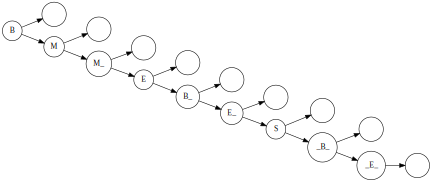

In [1]:
import graphviz
f = graphviz.Digraph()
f.attr(rankdir = 'LR',splines = 'line', size='6,6')
f.attr('node', shape='circle')
f.edge('B', '赫')
f.edge('M', '尔')
f.edge('M_', '辛')
f.edge('E', '基')
f.edge('B_', '大')
f.edge('E_', '学')
f.edge('S', '在')
f.edge('_B_', '芬')
f.edge('_E_', '兰')
f.edge('B','M')
f.edge('M','M_')
f.edge('M_','E')
f.edge('E','B_')
f.edge('B_','E_')
f.edge('E_','S')
f.edge('S','_B_')
f.edge('_B_','_E_')
f

### So we need to calculate the probability of transferring from one state to another state. Called transition probability. Also the probability of converting from state into observation, named emission probability. Chinese word segmentation actually belongs to decoding task in HMM. That's given transition and emission probabilities as well as an observation sequence, to discover the best hidden states of observation sequence. In addition, we also need initial probability so that we can have the :
$S=argmax(P(w_{1})*P(w_{2}|w_{1})*P(w_{3}|w_{2})...*P(w_{i}|w_{i-1}))$

### To search the best state combination, viterbi algorithm will also be used. 

### The following cells are codes for implementing HMM on Chinese word segmentation

In [2]:
with open(r'./training_and_testing_data/pku_training.txt',encoding='gbk') as f:# the path may need change
        content=f.readlines()
content="".join(content).strip()
#content=re.sub("。|？|！|\n","<end>",content)
content=content.split("\n")
while '  ' in content:
    content.remove('  ')
while '' in content:
    content.remove('')
for i,sentence in enumerate(content):
    content[i]=content[i].strip()

In [3]:
len('  '.join(content).split("  "))

1109947

In [5]:
import math
class HMM_CWS:
    def __init__(self):
        self.trans_prob={}
        self.emiss_prob={}
        self.initi_prob={}
        self.state_count={}
        
    def initialize(self):
        self.states=['B','M','E','S']
        for state in self.states:
            self.trans_prob[state]={}#initialize the transprob
            for next_state in self.states:
                self.trans_prob[state][next_state]=0 #{'B':{'B':0,'M':0,'E':0,'S':0},'M':...}
            self.state_count[state]=0
            self.emiss_prob[state]={}
            self.initi_prob[state]=0
    def observ_to_state(self,word):
        if len(word)==1:
            return 'S'
        if len(word) ==2:
            return 'BE'
        else:
            return 'B%sE'%('M'*(len(word)-2))#otherwise, for example a 4-character-long word should be 'BMME'
        
    def train_hmm(self,corpus):
        self.initialize()
        for sentence in corpus:
            state_sequence=[]
            for index,word in enumerate(sentence.split("  ")):
                if index ==0:#the word at the beginning should be added into initial_prob
                    state_sequence.extend(self.observ_to_state(word))
                    self.initi_prob[state_sequence[0]]+=1#add initial state to the initial prob, either B or S
                else:
                    state_sequence.extend(self.observ_to_state(word))
            #transition state
            for i,state in enumerate(state_sequence): # for state sequence: 'BEBESSBMMME', start from E, ignoring the first B
                self.trans_prob[state_sequence[i-1]][state]+=1#transition prob such as 'B->E'
            
            for i,char in enumerate(sentence.replace(' ','')):#add count for emission prob
                if char in self.emiss_prob[state_sequence[i]]:
                    self.emiss_prob[state_sequence[i]][char]+=1
                else:
                    self.emiss_prob[state_sequence[i]][char]=self.emiss_prob[state_sequence[i]].get(char,0)+1
        
        #convert frequency into prob
        initi_N=sum(self.initi_prob.values())
        for state in self.states:#compute the probability of initial_prob
            self.initi_prob[state]=-math.log((self.initi_prob[state]+1)/initi_N)# add one smoothing
        #calculate transition matrix prob
        for state in self.trans_prob:
            trans_N=sum(self.trans_prob[state].values())
            for next_state in self.trans_prob[state]:
                self.trans_prob[state][next_state]=-math.log((self.trans_prob[state][next_state]+1)/trans_N)
        #calculate the emission matrix prob
        for state in self.emiss_prob:
            emiss_N=sum(self.emiss_prob[state].values())
            for char in self.emiss_prob[state]:
                self.emiss_prob[state][char]=-math.log((self.emiss_prob[state][char]+1)/emiss_N)
        #return self.trans_prob,self.initi_prob,self.emiss_prob
        
    def split_sentence(self,sentence):
        pred_state_seq=[]
        last_state_prob={'B':0,'M':math.inf,'E':math.inf,'S':0}#since initial state is impossible to be M and E, so they are infinite
        ###calculate prob for each hidden state and record each path 
        for i,char in enumerate(sentence):
            if i ==0:#if the character is at the beginning, the hidden state can only be B(begin) or S (single word)
                pred_state_seq.append([(state,last_state_prob[state]+self.initi_prob[state]+self.emiss_prob[state].get(char,1)) for state in ['B','S']])
                # only B and S can be a state at the first beginning of a sentence, here get(char,1) 1 is default value for unseen observations. It might be a bit problematic.
                #pred_state_seq will add a tuple like: ('B', 4.578),('S','6.346')
                #There is one issue: how to deal with a unseen character whose emission prob doesn't exist
                for state in ['B','S']:
                    last_state_prob[state]=self.initi_prob[state]+self.emiss_prob[state].get(char,1)# equals to P(state|start)*P(character|state)
                #print(last_state_prob)
            else:
                current_state_prob=[]
                #print(i,char)
                for current_state in self.states:
                    #print(type(current_state),current_state,last_state_prob)
                    current_state_prob.append(min([(former_state,current_state,last_state_prob[former_state]+self.trans_prob[former_state][current_state]+self.emiss_prob[current_state].get(char,1)) for former_state in self.states],key=lambda x:x[-1]))
                    #current_state_prob will include a tuple like ('B','E',5.346) where 'E' is current state and its best former state is 'B'
                for i,current_state in enumerate(self.states):
                    last_state_prob[current_state]=current_state_prob[i][-1]#renew the weight for each state
                    #print(current_state_prob)
                pred_state_seq.append(current_state_prob)#will record every state at present and its best previous state and prob
        #print(last_state_prob)
        #print(pred_state_seq)
        
        best_former_state,best_current_state,prob=min([x for x in pred_state_seq[-1] if x[1] in ['E','S']],key=lambda x:x[-1])
        #Only 'E' and 'S' make sense for the last state, so compare the total weight of two paths. Select best last state
        final_state=[]
        final_state.append(best_current_state)
        for i in range(len(pred_state_seq)-2,0,-1):#tracing back, so the index should be from large to small
            best_former_state, best_current_state,prob=[x for x in pred_state_seq[i] if x[1]==best_former_state][0]
            final_state.append(best_current_state)
        final_state.append(best_former_state)
        #print(final_state[::-1])
        
        ###convert states into word segmentations
        word_split,start,end=[],0,0
        for i,state in enumerate(final_state[::-1]):
            #print(i)
            if state=='B':
                start=i
            elif state =='E':
                end=i
                word_split.append(sentence[start:end+1])#add the segmentation into split list
            elif state == 'S':
                word_split.append(sentence[i:i+1])
        return '  '.join(word_split)
                
hmm=HMM_CWS()
hmm.train_hmm(content)

In [33]:
hmm.split_sentence("我的同学叫罗逸凡")# My classmate whose name is Luo Yifan, and the HMM successfully recognizes a name: 罗（Luo）逸凡（Yifan）

'我  的  同学  叫  罗  逸凡'

In [213]:
with open(r'./training_and_testing_data/pku_test.txt',encoding='gbk') as f:# the path may need change
    test=f.readlines()
for i,s in enumerate(test):
    test[i]=hmm.split_sentence(s)

In [177]:
with open('pku_test_segmentation_hmm.txt',"a") as f:
    f.writelines(test)